In [34]:
import copy
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
from os.path import join as oj
from tqdm import tqdm
import pickle

from imodels.importance import R2FExp, GeneralizedMDI, GeneralizedMDIJoint
from imodels.importance import LassoScorer, RidgeScorer, ElasticNetScorer, RobustScorer, LogisticScorer, JointRidgeScorer, JointLogisticScorer, JointRobustScorer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import shap
from feature_importance.scripts.mda import MDA
import sklearn.metrics as metrics

import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_bar, theme, element_text

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATA_DIR = "../../data"
RESULTS_DIR = "../../results/tcga_brca"
N_REPS = 10
FI_MODELS = ["gjmdi_loocv", "gjmdi_f1", "mdi", "shap", "permutation", "mda"]
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR, exist_ok=True)

## Load TCGA RNA-Seq data

In [3]:
X_df = pd.read_csv(oj(DATA_DIR, "X_tcga_var_filtered_log_transformed.csv"))
X = X_df.to_numpy()
y = pd.read_csv(oj(DATA_DIR, "Y_tcga.csv")).to_numpy().ravel()

In [4]:
X_df.head()

,A2M,NAT1,RP11.986E7.7,AAMP,AARS,ABAT,ABCA2,ABCA3,ABCF1,ABL1,...,EIF3CL.1,PLIN4,MTPN,RELL1,SNHG8.1,OST4,TSTD1,GAGE12J.4,NBPF10,PRICKLE4.1
0,9.614527,7.401763,10.859011,7.765291,7.625208,7.715826,7.500286,6.677448,7.228231,7.572464,...,9.237782,5.359995,8.073793,6.500534,6.411474,7.729637,7.369472,0.000000,6.609727,7.551117
1,8.725323,9.375599,10.128432,7.388699,7.658290,7.463426,7.031804,8.702240,7.566244,7.363025,...,9.349586,6.583817,8.185900,6.551568,3.425952,7.161099,7.052134,0.000000,7.665767,7.310317
2,8.671585,7.756825,10.690369,8.064953,7.976935,8.461162,7.444768,8.378548,7.731562,7.365497,...,9.417242,4.251032,8.359054,7.816944,5.631785,7.984734,7.587183,0.309101,6.425312,7.941761
3,9.339170,6.155162,7.340154,7.815608,8.993226,6.216886,6.922385,7.906770,8.111439,7.358005,...,9.887913,4.239956,8.562925,7.082101,7.108862,7.414290,5.987086,0.000000,7.137403,7.841682
4,8.909420,4.402246,8.196574,8.366875,7.949886,5.881482,8.076330,7.432998,7.809034,7.864155,...,9.525658,5.304333,8.157452,6.425711,6.033721,8.060675,7.341724,0.000000,6.776412,7.650708


In [5]:
y

array(['LumA', 'LumB', 'LumA', ..., 'LumA', 'LumA', 'LumA'], dtype=object)

In [6]:
X.shape, y.shape

((1083, 5000), (1083,))

## Helper Functions

In [7]:
# f1 score for multi-class classification
def multiclass_f1_score(y_onehot, ypreds, sample_weight=None):
    ypreds_label = ypreds.argmax(axis=1)
    y_label = y_onehot.argmax(axis=1)
    results = np.zeros(ypreds.shape[1])
    for k in range(ypreds.shape[1]):
        ypreds_k = (ypreds_label == k).astype(int)
        y_k = (y_label == k).astype(int)
        results[k] = metrics.f1_score(y_k, ypreds_k)
    return results

In [8]:
# helper functions to reformat results
def importance_dict_to_df(d, X_df):
    df = pd.DataFrame(d)
    df["feature"] = X_df.columns
    return df


def class_scores_dict_to_df(d, X_df):
    df_ls = []
    for i, df in enumerate(d.values()):
        df["rep"] = i
        df["feature"] = X_df.columns
        df_ls.append(df)
    df = pd.concat(df_ls).reset_index(drop=True)
    return df

def dict_to_df(d, col_id):
    df_ls = []
    for key, df in d.items():
        df[col_id] = key
        df_ls.append(df)
    df = pd.concat(df_ls).reset_index(drop=True)
    return df

In [9]:
# check if in top r
def isin_top_r(x, r=10):
    return x > x.sort_values(ascending=False).values[r]


# count frequency in top r
def top_r_stability(df, r=10):
    top_r_df = pd.DataFrame({
        "feature": df["feature"],
        "top_r_stability": df.drop(["feature"], axis=1).\
            apply(isin_top_r, axis=0, r=r).mean(axis=1)
    })
    return top_r_df.sort_values("top_r_stability", ascending=False)

## Run stability analysis

In [ ]:
# initialize outputs
gjmdi_loocv_imp_values_dict = {}
gjmdi_f1_imp_values_dict = {}
mdi_imp_values_dict = {}
perm_imp_values_dict = {}
mda_imp_values_dict = {}
shap_imp_values_dict = {}

gjmdi_loocv_class_scores_dict = {}
gjmdi_f1_class_scores_dict = {}
shap_class_scores_dict = {}

for rep in tqdm(range(N_REPS)):
    rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt", random_state=rep)

    if "gjmdi_loocv" in FI_MODELS:
        loocv_scorer = JointRidgeScorer(criterion="gcv", metric="loocv")
        gjMDI_loocv = GeneralizedMDIJoint(copy.deepcopy(rf_model), scorer=loocv_scorer, normalize_raw=True, random_state=331)
        imp_values, _, class_scores, _, _ = gjMDI_loocv.get_importance_scores(X, y, diagnostics=True)
        gjmdi_loocv_imp_values_dict[rep] = copy.deepcopy(imp_values)
        gjmdi_loocv_class_scores_dict[rep] = copy.deepcopy(class_scores.drop("tree", axis=1).
                                                           groupby("feature").agg("mean").reset_index())

    if "gjmdi_f1" in FI_MODELS:
        f1_scorer = JointRidgeScorer(criterion="gcv", metric=multiclass_f1_score)
        gjMDI_f1 = GeneralizedMDIJoint(copy.deepcopy(rf_model), scorer=f1_scorer, normalize_raw=True, random_state=331)
        imp_values, _, class_scores, _, _ = gjMDI_f1.get_importance_scores(X, y, diagnostics=True)
        gjmdi_f1_imp_values_dict[rep] = copy.deepcopy(imp_values)
        gjmdi_f1_class_scores_dict[rep] = copy.deepcopy(class_scores.drop("tree", axis=1).
                                                        groupby("feature").agg("mean").reset_index())

    rf_model.fit(X, y)

    if "mdi" in FI_MODELS:
        mdi_imp_values_dict[rep] = rf_model.feature_importances_

    if "permutation" in FI_MODELS:
        rf_model_perm = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt", random_state=rep)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rep + 500)
        rf_model_perm.fit(X_train, y_train)
        perm_fit = permutation_importance(rf_model, X_test, y_test, n_repeats=5, random_state=rep + 100)
        perm_imp_values_dict[rep] = copy.deepcopy(perm_fit.importances_mean)

    if "shap" in FI_MODELS:
        explainer = shap.TreeExplainer(rf_model)
        shap_values = explainer.shap_values(X)
        class_scores = pd.DataFrame({class_id: np.abs(shap_values[idx]).mean(axis=0) for idx, class_id in enumerate(rf_model.classes_)})
        shap_imp_values_dict[rep] = copy.deepcopy(class_scores.mean(axis=1))
        # class_scores["feature"] = X_df.columns
        shap_class_scores_dict[rep] = copy.deepcopy(class_scores)

    if "mda" in FI_MODELS:
        y_factorized = pd.factorize(y.ravel())
        y_mda = y_factorized[0]
        rf_model_mda = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt", random_state=rep)
        rf_model_mda.fit(X, y_mda)
        mda_out, _ = MDA(rf_model_mda, X, y_mda[:, np.newaxis], type="oob", n_trials=5, metric="accuracy")
        mda_imp_values_dict[rep] = copy.deepcopy(mda_out)

if "gjmdi_loocv" in FI_MODELS:
    pickle.dump(gjmdi_loocv_imp_values_dict, open(oj(RESULTS_DIR, "gjmdi_loocv_imp_values_dict.pickle"), 'wb'))
    pickle.dump(gjmdi_loocv_class_scores_dict, open(oj(RESULTS_DIR, "gjmdi_loocv_class_scores_dict.pickle"), 'wb'))

if "gjmdi_f1" in FI_MODELS:
    pickle.dump(gjmdi_f1_imp_values_dict, open(oj(RESULTS_DIR, "gjmdi_f1_imp_values_dict.pickle"), 'wb'))
    pickle.dump(gjmdi_f1_class_scores_dict, open(oj(RESULTS_DIR, "gjmdi_f1_class_scores_dict.pickle"), 'wb'))

if "mdi" in FI_MODELS:
    pickle.dump(mdi_imp_values_dict, open(oj(RESULTS_DIR, "mdi_imp_values_dict.pickle"), 'wb'))

if "shap" in FI_MODELS:
    pickle.dump(shap_imp_values_dict, open(oj(RESULTS_DIR, "shap_imp_values_dict.pickle"), 'wb'))
    pickle.dump(shap_class_scores_dict, open(oj(RESULTS_DIR, "shap_class_scores_dict.pickle"), 'wb'))

if "permutation" in FI_MODELS:
    pickle.dump(perm_imp_values_dict, open(oj(RESULTS_DIR, "perm_imp_values_dict.pickle"), 'wb'))

if "mda" in FI_MODELS:
    pickle.dump(mda_imp_values_dict, open(oj(RESULTS_DIR, "mda_imp_values_dict.pickle"), 'wb'))


## Load in stability analysis results

In [10]:
gjmdi_loocv_imp_values_dict = pickle.load(
    open(oj(RESULTS_DIR, "gjmdi_loocv_imp_values_dict.pickle"), 'rb')
)
gjmdi_loocv_class_scores_dict = pickle.load(
    open(oj(RESULTS_DIR, "gjmdi_loocv_class_scores_dict.pickle"), 'rb')
)

gjmdi_f1_imp_values_dict = pickle.load(
    open(oj(RESULTS_DIR, "gjmdi_f1_imp_values_dict.pickle"), 'rb')
)
gjmdi_f1_class_scores_dict = pickle.load(
    open(oj(RESULTS_DIR, "gjmdi_f1_class_scores_dict.pickle"), 'rb')
)

mdi_imp_values_dict = pickle.load(
    open(oj(RESULTS_DIR, "mdi_imp_values_dict.pickle"), 'rb')
)

shap_imp_values_dict = pickle.load(
    open(oj(RESULTS_DIR, "shap_imp_values_dict.pickle"), 'rb')
)
shap_class_scores_dict = pickle.load(
    open(oj(RESULTS_DIR, "shap_class_scores_dict.pickle"), 'rb')
)

perm_imp_values_dict = pickle.load(
    open(oj(RESULTS_DIR, "perm_imp_values_dict.pickle"), 'rb')
)

mda_imp_values_dict = pickle.load(
    open(oj(RESULTS_DIR, "mda_imp_values_dict.pickle"), 'rb')
)

In [11]:
gjmdi_loocv_imp_df = importance_dict_to_df(gjmdi_loocv_imp_values_dict, X_df)
gjmdi_f1_imp_df = importance_dict_to_df(gjmdi_f1_imp_values_dict, X_df)
mdi_imp_df = importance_dict_to_df(mdi_imp_values_dict, X_df)
shap_imp_df = importance_dict_to_df(shap_imp_values_dict, X_df)
perm_imp_df = importance_dict_to_df(perm_imp_values_dict, X_df)
mda_imp_df = importance_dict_to_df(mda_imp_values_dict, X_df)

gjmdi_loocv_class_scores_df = class_scores_dict_to_df(gjmdi_loocv_class_scores_dict, X_df)
gjmdi_f1_class_scores_df = class_scores_dict_to_df(gjmdi_f1_class_scores_dict, X_df)
shap_class_scores_df = class_scores_dict_to_df(shap_class_scores_dict, X_df)

In [12]:
gjmdi_loocv_imp_df.head()

,0,1,2,3,4,5,6,7,8,9,feature
0,-0.665831,-0.661924,-0.664784,-0.664343,-0.664893,-0.663706,-0.665791,-0.662762,-0.664317,-0.666209,A2M
1,-0.662533,-0.658207,-0.662146,-0.663204,-0.660136,-0.659563,-0.661736,-0.657861,-0.660137,-0.662083,NAT1
2,-0.665673,-0.661365,-0.664121,-0.664184,-0.663576,-0.662804,-0.665021,-0.662597,-0.663906,-0.666189,RP11.986E7.7
3,-0.665830,-0.671683,-0.664665,-0.664618,-0.664970,-0.663535,-0.667354,-0.662751,-0.664128,-0.668491,AAMP
4,-0.665830,-0.661445,-0.664666,-0.664202,-0.664082,-0.663535,-0.665502,-0.662508,-0.664725,-0.665935,AARS


In [13]:
gjmdi_f1_imp_df.head()

,0,1,2,3,4,5,6,7,8,9,feature
0,0.323485,0.343167,0.348066,0.373627,0.338722,0.376674,0.387692,0.372932,0.367956,0.368893,A2M
1,0.388093,0.395603,0.364168,0.362278,0.371403,0.363690,0.358941,0.349023,0.354940,0.398094,NAT1
2,0.377143,0.355554,0.363313,0.357580,0.349207,0.352403,0.357190,0.343081,0.359650,0.363907,RP11.986E7.7
3,0.343175,0.369552,0.336129,0.350456,0.383690,-inf,0.373643,0.310446,0.378287,0.360180,AAMP
4,0.369448,0.339493,-inf,0.370705,0.403706,-inf,-inf,0.371756,0.360822,0.356209,AARS


In [14]:
mdi_imp_df.head()

,0,1,2,3,4,5,6,7,8,9,feature
0,0.000019,0.000261,0.000116,0.000113,0.000391,0.000180,0.000357,0.000139,0.000531,0.000316,A2M
1,0.003123,0.003366,0.001210,0.000853,0.003019,0.003357,0.000625,0.001986,0.001944,0.003738,NAT1
2,0.000318,0.001015,0.000463,0.000301,0.000844,0.000789,0.000703,0.000258,0.000422,0.000295,RP11.986E7.7
3,0.000027,0.000109,0.000019,0.000097,0.000040,0.000000,0.000028,0.000049,0.000025,0.000077,AAMP
4,0.000115,0.000434,0.000000,0.000252,0.000061,0.000000,0.000000,0.000265,0.000292,0.000319,AARS


In [15]:
shap_imp_df.head()

,0,1,2,3,4,5,6,7,8,9,feature
0,0.000006,0.000093,0.000062,0.000052,0.000151,0.000103,0.000160,0.000068,0.000262,0.000118,A2M
1,0.001170,0.001506,0.000525,0.000476,0.001273,0.001279,0.000453,0.001014,0.001115,0.001473,NAT1
2,0.000140,0.000389,0.000199,0.000136,0.000502,0.000364,0.000237,0.000081,0.000158,0.000110,RP11.986E7.7
3,0.000006,0.000033,0.000008,0.000035,0.000020,0.000000,0.000014,0.000015,0.000006,0.000038,AAMP
4,0.000033,0.000240,0.000000,0.000122,0.000064,0.000000,0.000000,0.000133,0.000205,0.000150,AARS


In [16]:
perm_imp_df.head()

,0,1,2,3,4,5,6,7,8,9,feature
0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,-0.001676,0.000000,0.002793,-0.003352,A2M
1,4.440892e-17,-0.001676,0.000000,-0.001117,-0.002793,0.005028,0.000000,-0.002793,0.004469,-0.001117,NAT1
2,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000559,0.000000,-0.001117,0.000000,0.000000,RP11.986E7.7
3,0.000000e+00,0.000000,0.002235,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001117,AAMP
4,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,AARS


In [17]:
mda_imp_df.head()

,0,1,2,3,4,5,6,7,8,9,feature
0,0.000000,0.000206,0.000050,0.000025,0.000246,0.000136,0.000040,3.519268e-05,0.000371,0.000140,A2M
1,0.002313,0.002440,0.001252,0.001064,0.003530,0.002080,0.001865,2.151781e-03,0.003037,0.002770,NAT1
2,0.000070,0.000271,0.000241,0.000176,0.000201,0.000578,-0.000015,5.027526e-05,0.000125,-0.000005,RP11.986E7.7
3,0.000000,0.000015,0.000030,-0.000010,0.000005,0.000000,0.000005,-2.011010e-05,-0.000010,0.000065,AAMP
4,0.000040,0.000050,0.000000,0.000130,0.000080,0.000000,0.000000,1.110223e-16,0.000402,0.000125,AARS


In [18]:
gjmdi_loocv_class_scores_df.head()

,feature,Basal,Her2,LumA,LumB,Normal,rep
0,A2M,-0.752485,-2.587296,-0.003393,-0.625342,-6.511512,0
1,NAT1,-0.747121,-2.587090,0.001130,-0.625083,-6.512907,0
2,RP11.986E7.7,-0.752910,-2.586037,-0.002991,-0.625418,-6.513604,0
3,AAMP,-0.752486,-2.587299,-0.003390,-0.625338,-6.511520,0
4,AARS,-0.752475,-2.587306,-0.003391,-0.625341,-6.511527,0


In [19]:
gjmdi_f1_class_scores_df.head()

,feature,Basal,Her2,LumA,LumB,Normal,rep
0,A2M,0.000000,0.0,0.658703,0.0,0.0,0
1,NAT1,0.130536,0.0,0.699196,0.0,0.0,0
2,RP11.986E7.7,0.000000,0.0,0.699799,0.0,0.0,0
3,AAMP,0.000000,0.0,0.674457,0.0,0.0,0
4,AARS,0.000000,0.0,0.694491,0.0,0.0,0


In [20]:
shap_class_scores_df.head()

,Basal,Her2,LumA,LumB,Normal,rep,feature
0,0.000000,0.000000,0.000015,0.000015,0.000000,0,A2M
1,0.002650,0.000446,0.001696,0.000912,0.000148,0,NAT1
2,0.000012,0.000094,0.000290,0.000202,0.000101,0,RP11.986E7.7
3,0.000000,0.000014,0.000014,0.000000,0.000000,0,AAMP
4,0.000000,0.000006,0.000083,0.000077,0.000000,0,AARS


In [21]:
imp_dict = {
    "gjmdi_loocv": gjmdi_loocv_imp_df,
    "gjmdi_f1": gjmdi_f1_imp_df,
    "mdi": mdi_imp_df,
    "shap": shap_imp_df,
    "permutation": perm_imp_df,
    "mda": mda_imp_df
}

## Visualize stability results

Check stability in top 10

In [22]:
stability_dict = {key: top_r_stability(df, r=10) for key, df in imp_dict.items()}

In [23]:
for key, df in stability_dict.items():
    print(key)
    print(df)

gjmdi_loocv
         feature  top_r_stability
626         ESR1              1.0
688        FOXM1              0.9
3114        TPX2              0.9
731        GATA3              0.8
885        FOXA1              0.7
...          ...              ...
1673        RPA1              0.0
1672        RORC              0.0
1671       ROCK1              0.0
1670       ROBO2              0.0
4999  PRICKLE4.1              0.0

[5000 rows x 2 columns]
gjmdi_f1
         feature  top_r_stability
885        FOXA1              0.8
2844        AGR2              0.4
3350       SPDEF              0.3
2554       TTLL4              0.3
4694       DEGS2              0.3
...          ...              ...
1678        RPL7              0.0
1677        RPL6              0.0
1676        RPL5              0.0
1675        RPL4              0.0
4999  PRICKLE4.1              0.0

[5000 rows x 2 columns]
mdi
         feature  top_r_stability
3114        TPX2              0.7
626         ESR1              0.5
885    

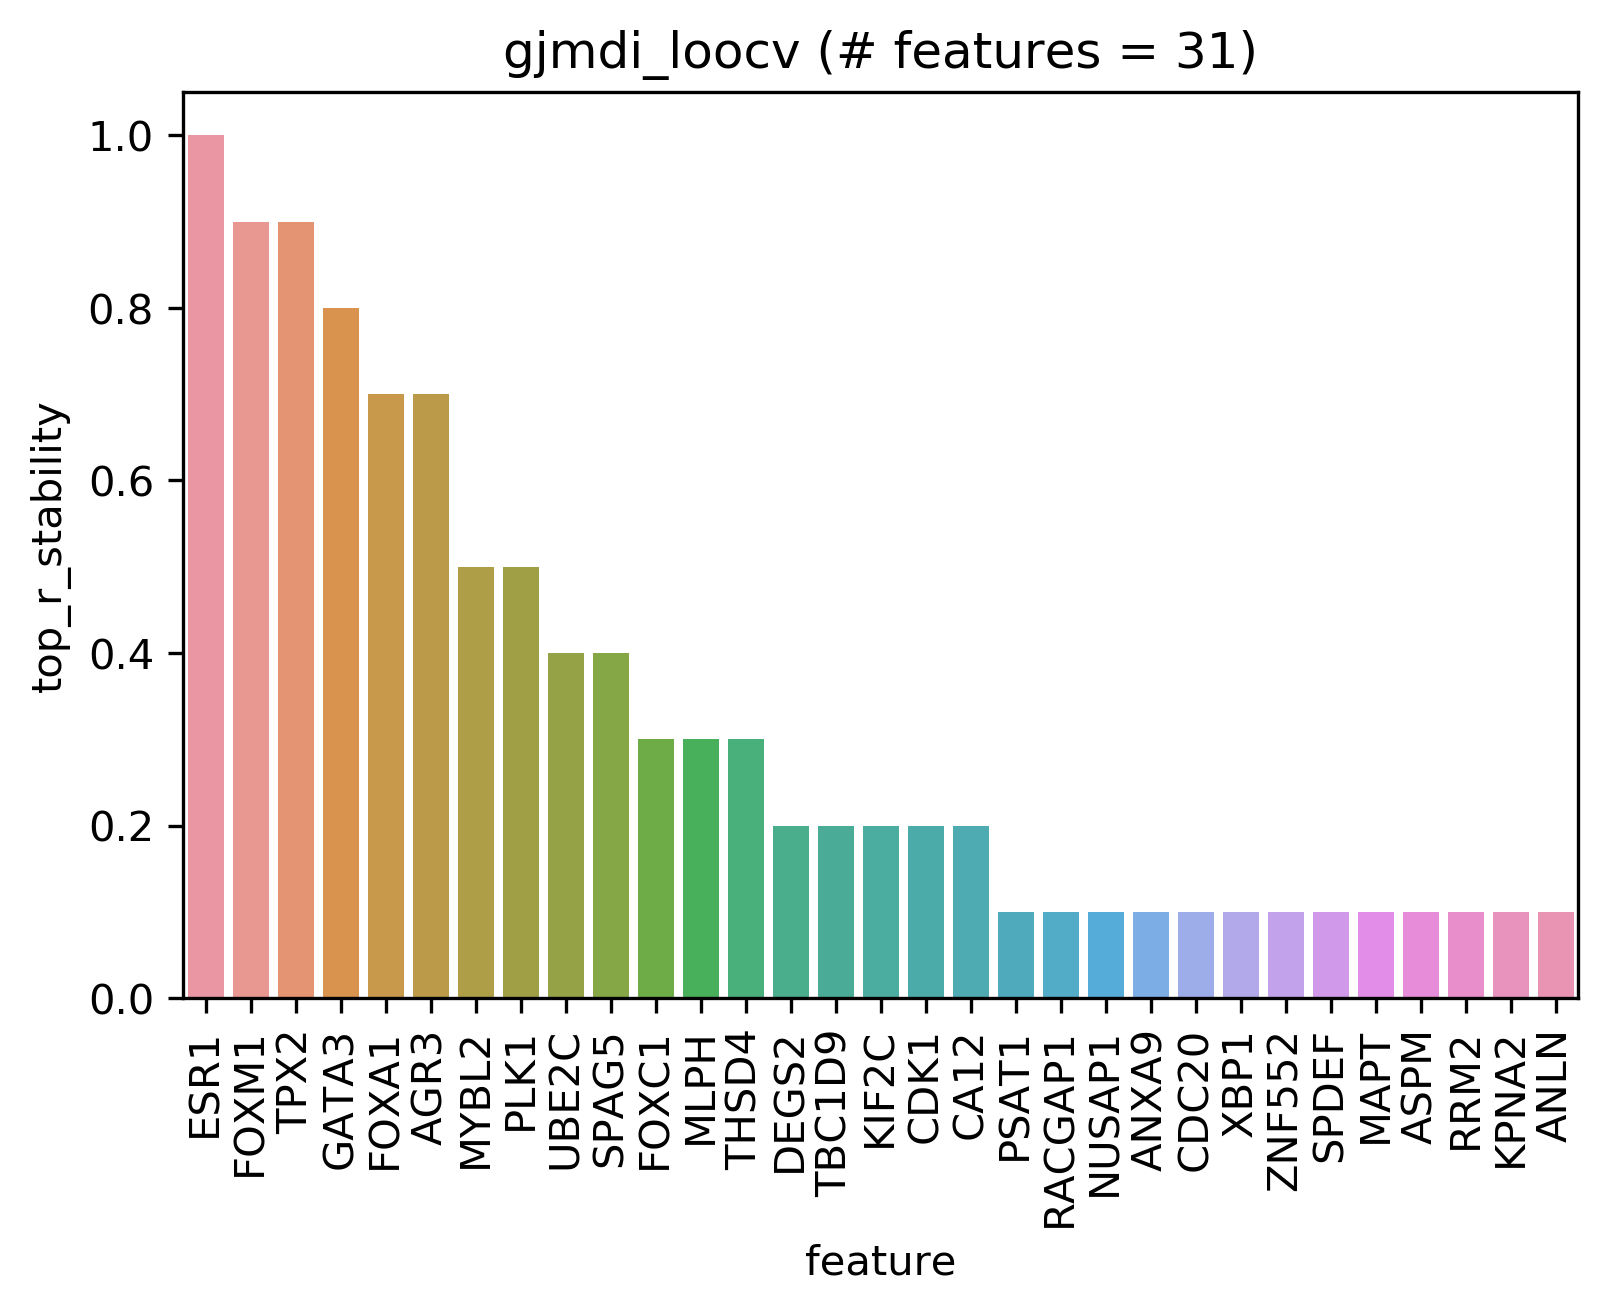

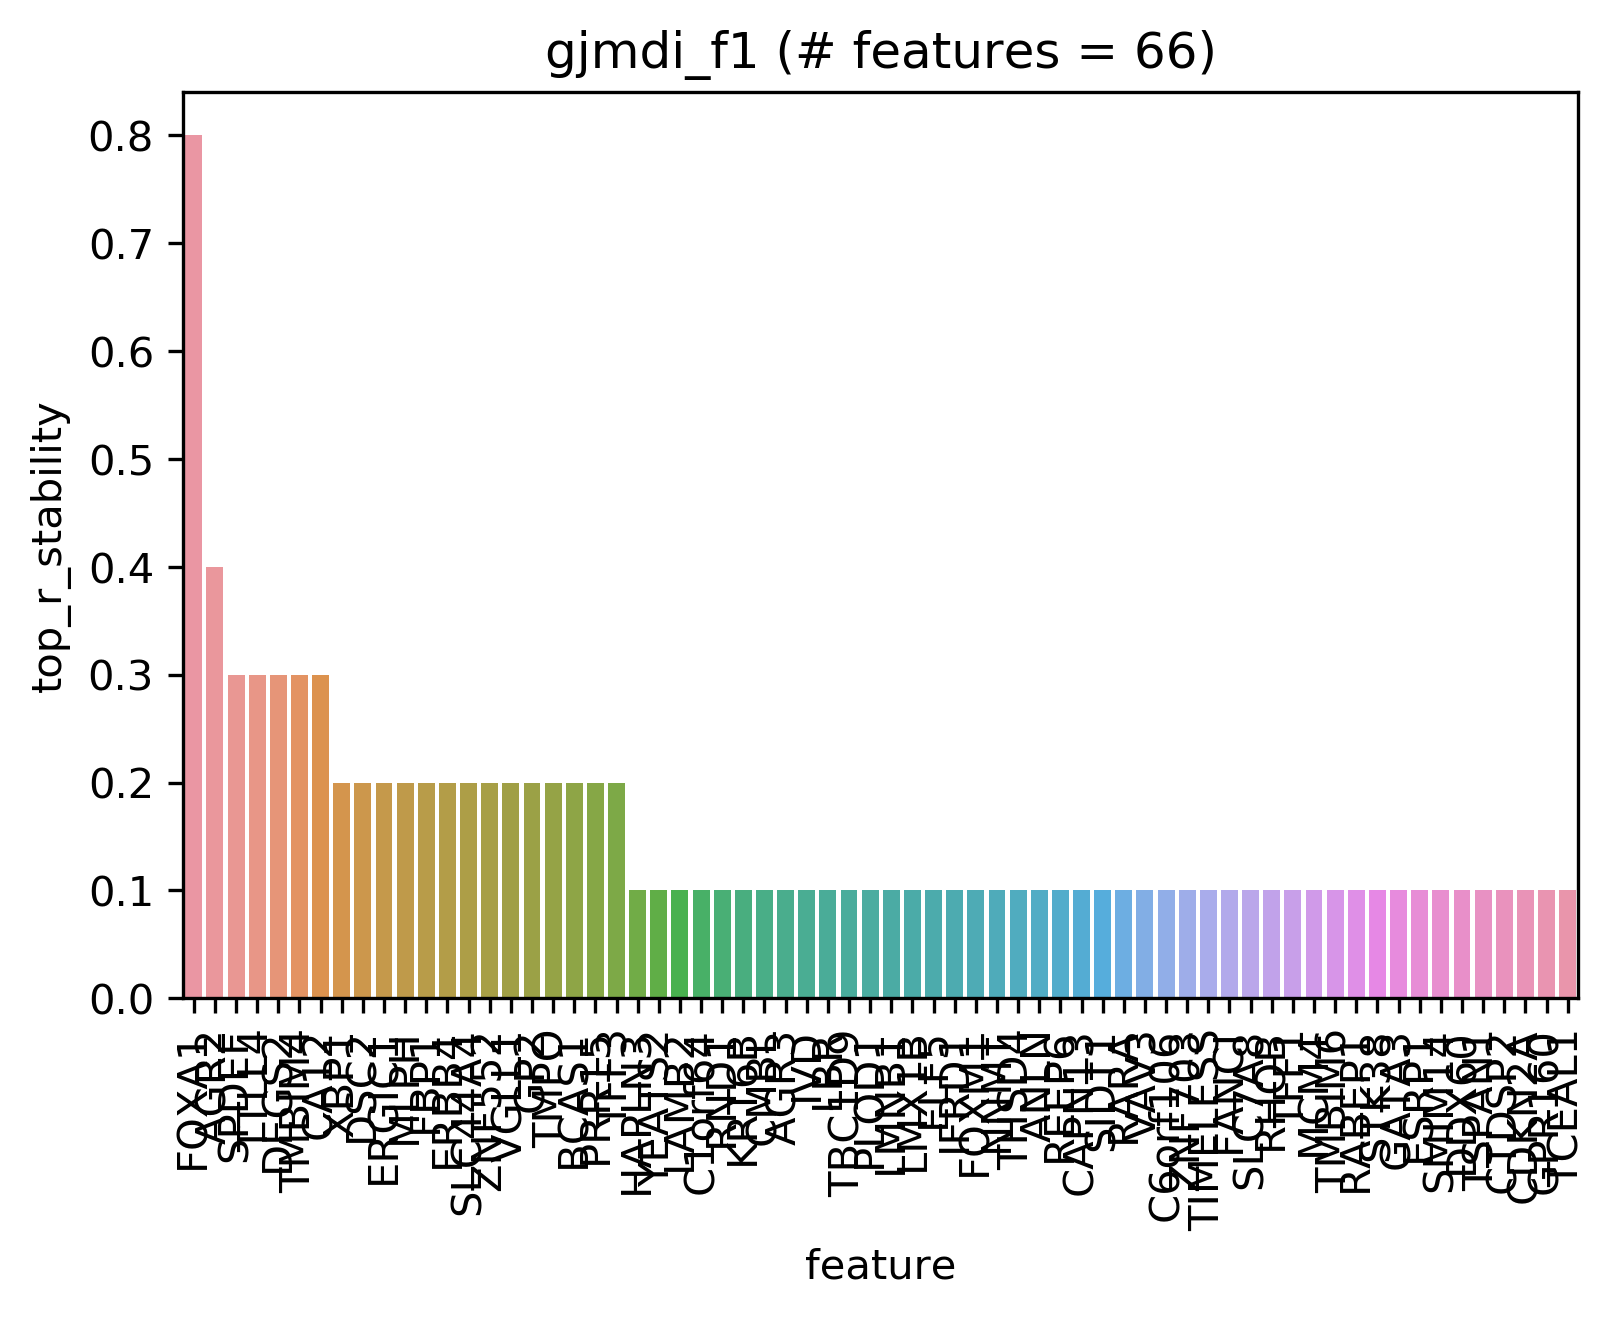

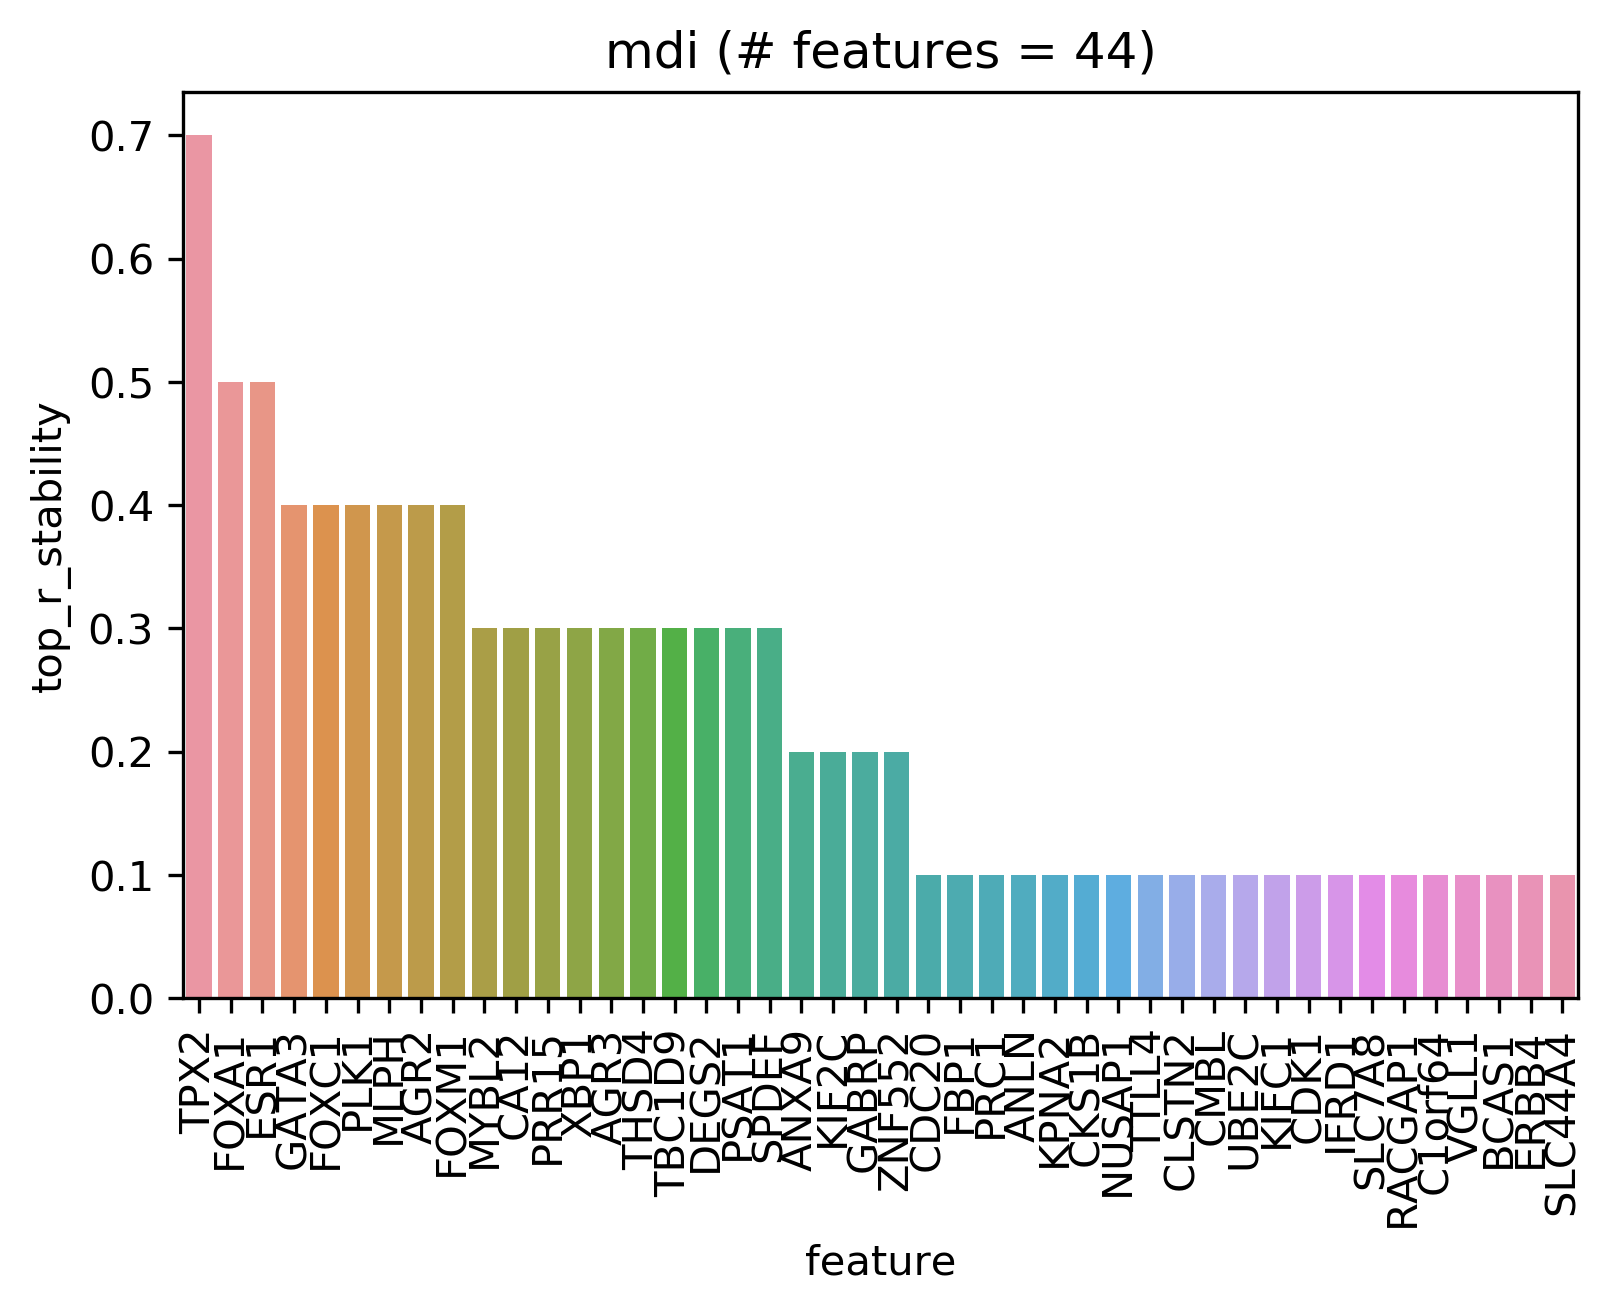

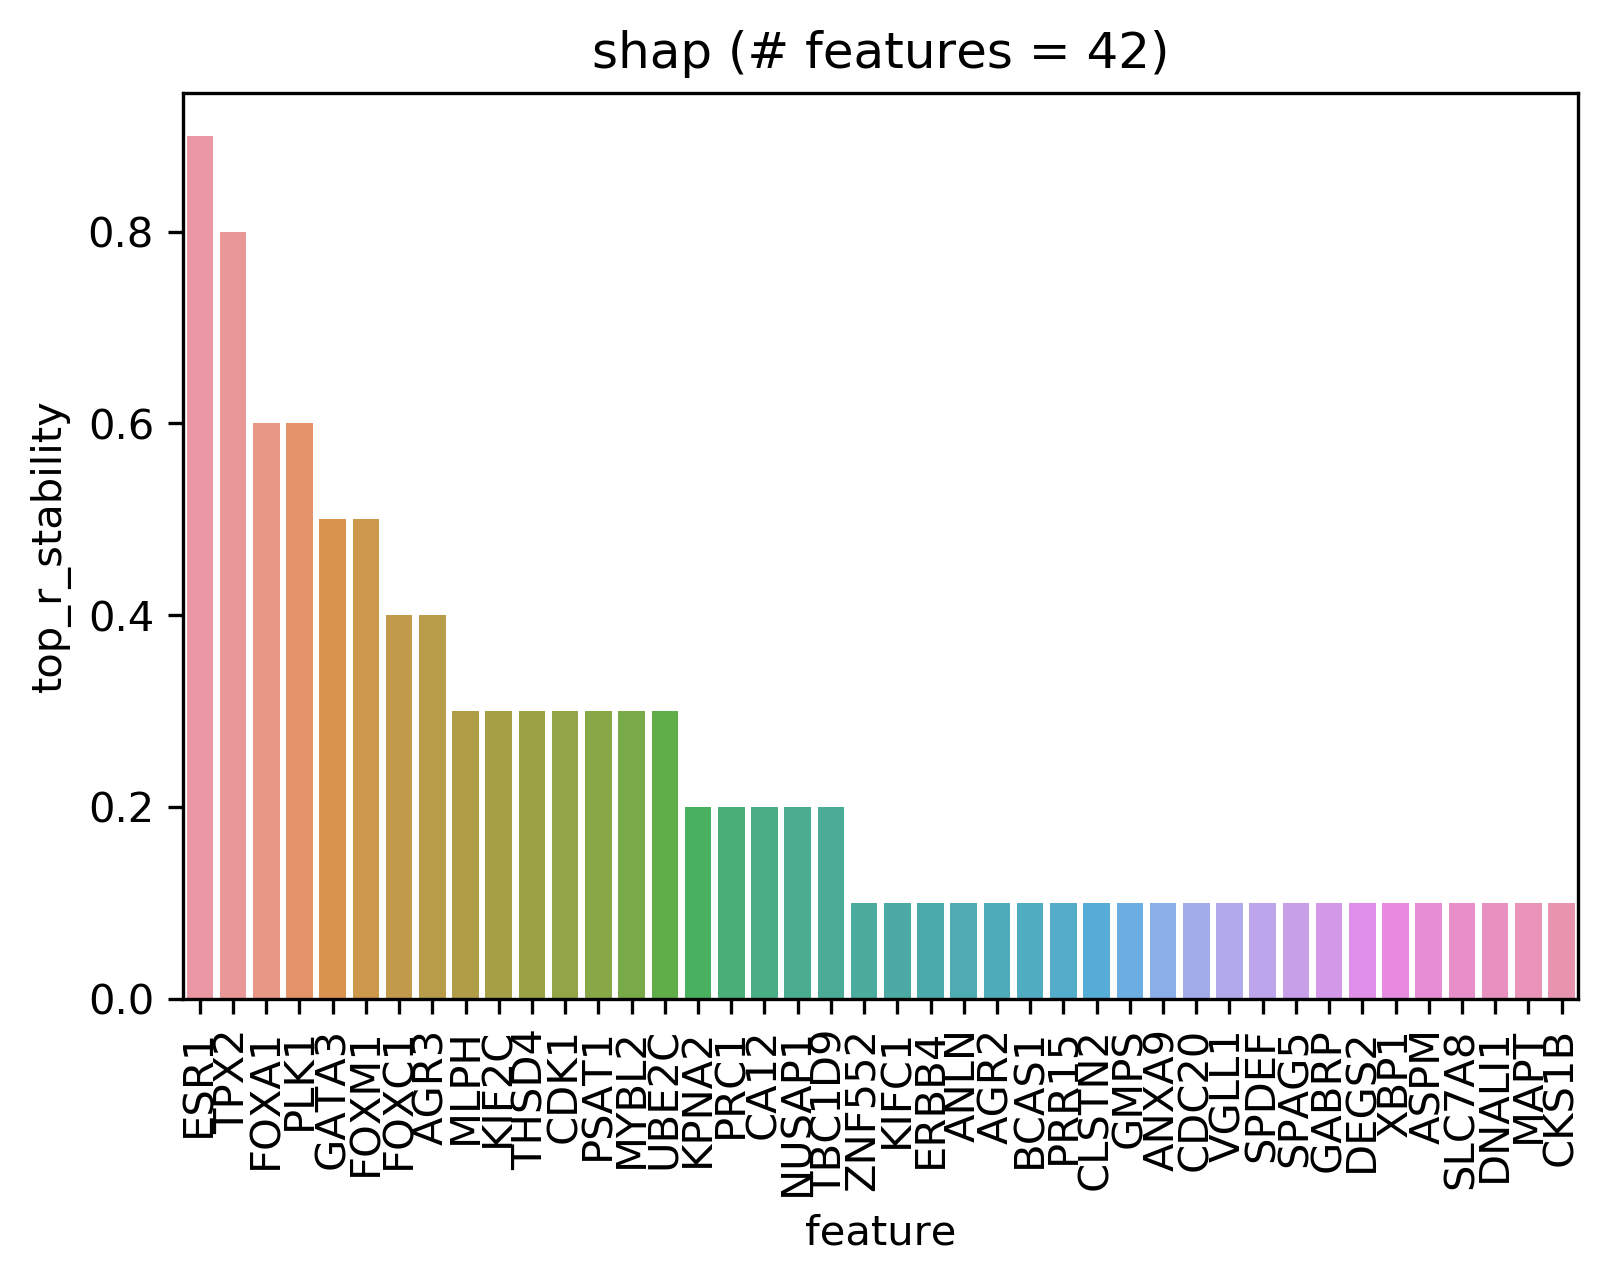

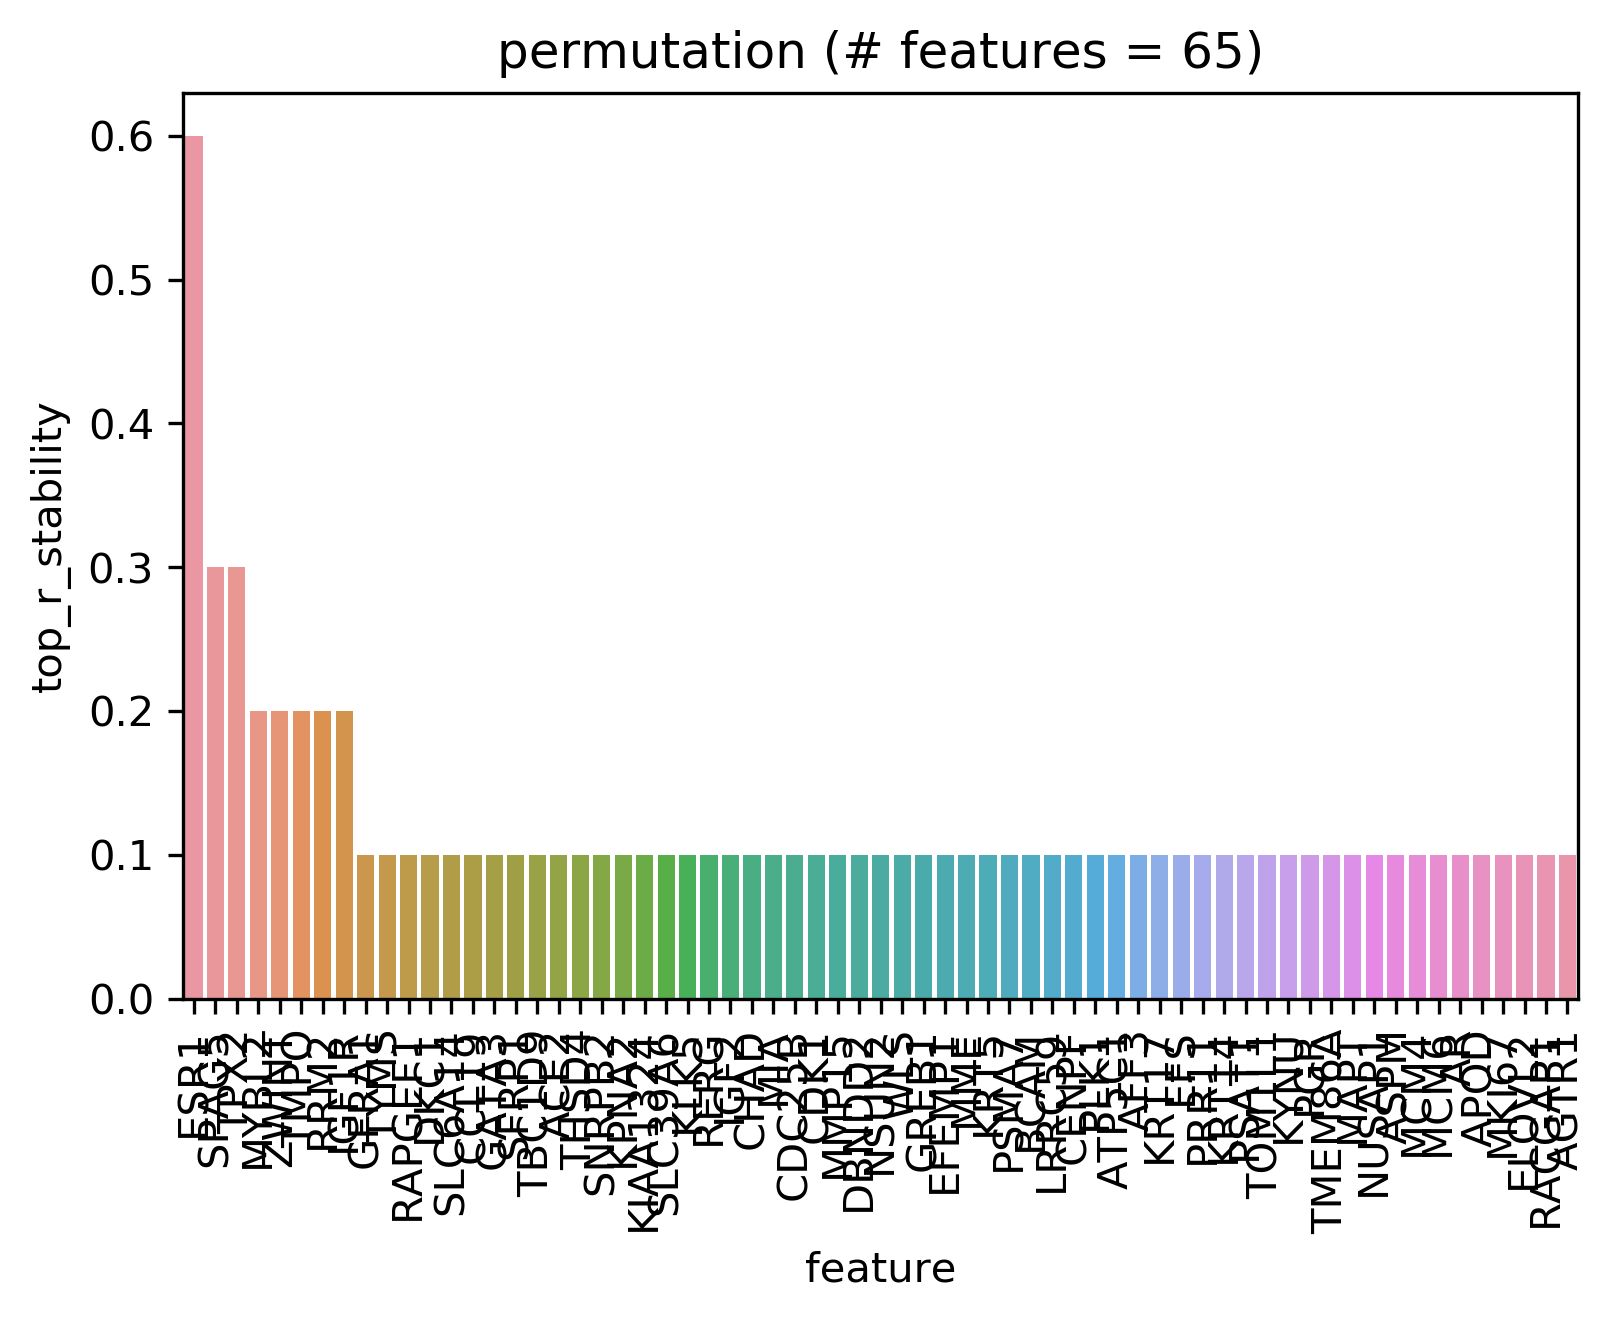

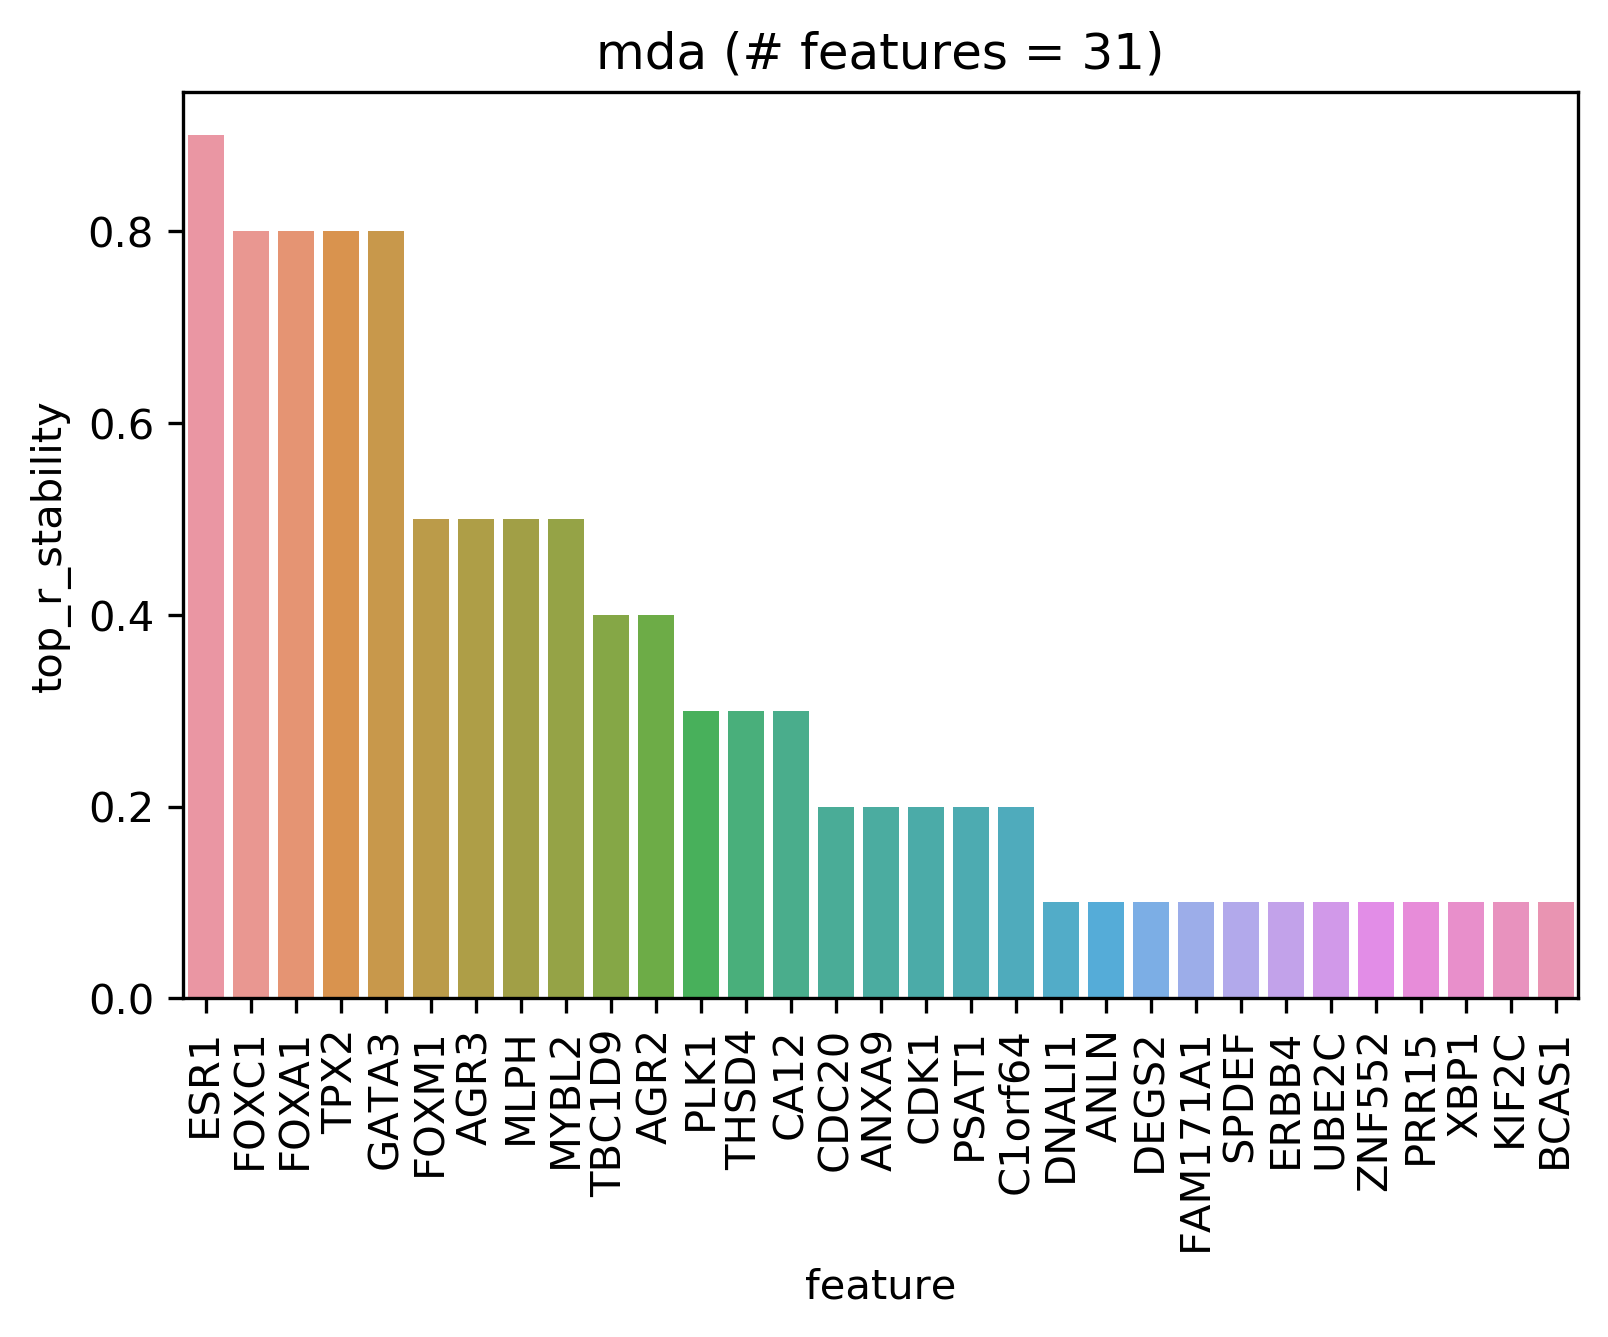

In [24]:
for key, df in stability_dict.items():
    df = df[df["top_r_stability"] > 0]
    ax = sns.barplot(
        x="feature", y="top_r_stability", data=df,
        order=df.sort_values("top_r_stability", ascending=False)["feature"]
    )
    ax.set_title("{} (# features = {})".format(key, df.shape[0]))
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    plt.show()

Check stability in top 5

In [95]:
stability_dict = {key: top_r_stability(df, r=5) for key, df in imp_dict.items()}

In [96]:
for key, df in stability_dict.items():
    print(key)
    print(df)

gjmdi_loocv
         feature  top_r_stability
626         ESR1              1.0
3114        TPX2              0.8
731        GATA3              0.7
688        FOXM1              0.5
885        FOXA1              0.4
...          ...              ...
1672        RORC              0.0
1671       ROCK1              0.0
1670       ROBO2              0.0
1669       ROBO1              0.0
4999  PRICKLE4.1              0.0

[5000 rows x 2 columns]
gjmdi_f1
         feature  top_r_stability
2844        AGR2              0.4
2554       TTLL4              0.3
885        FOXA1              0.3
4289        MLPH              0.2
3724      TMBIM4              0.2
...          ...              ...
1671       ROCK1              0.0
1670       ROBO2              0.0
1669       ROBO1              0.0
1668       ABCE1              0.0
4999  PRICKLE4.1              0.0

[5000 rows x 2 columns]
mdi
         feature  top_r_stability
626         ESR1              0.5
885        FOXA1              0.5
688    

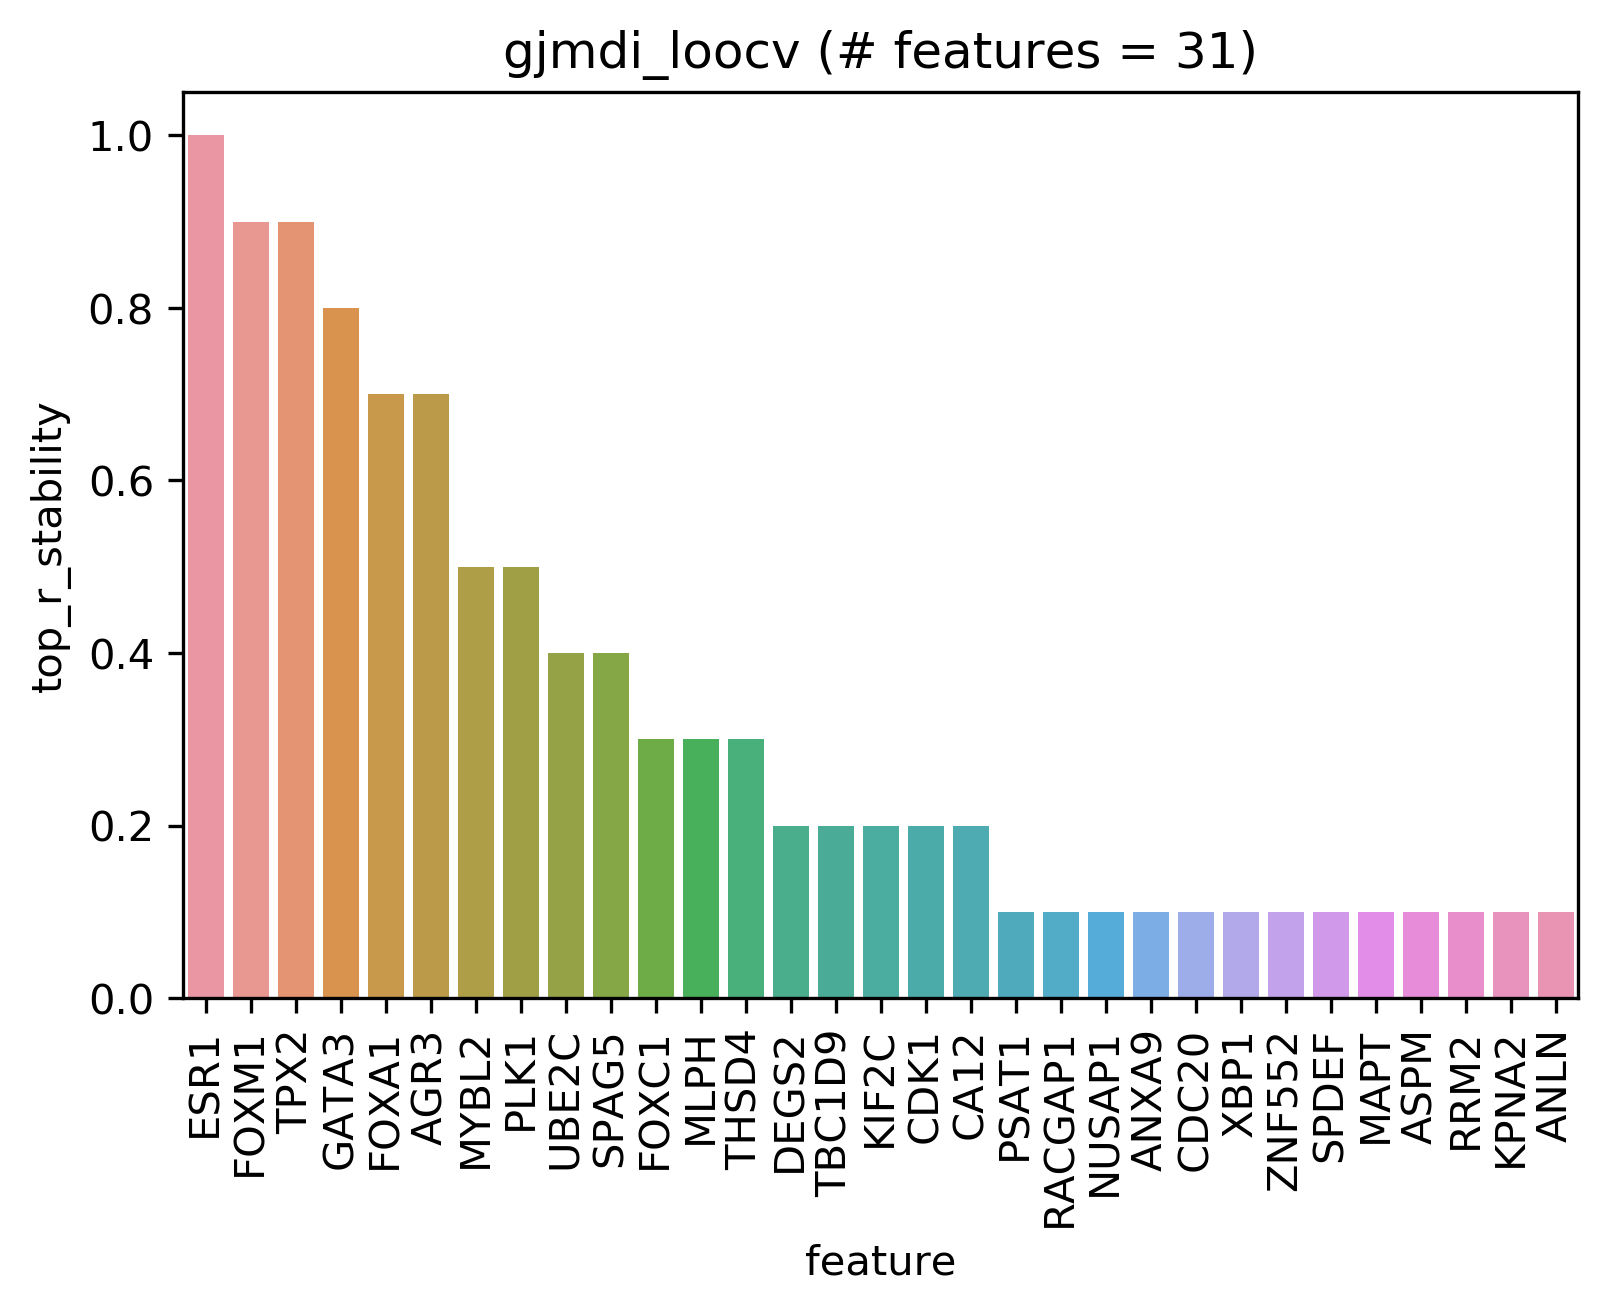

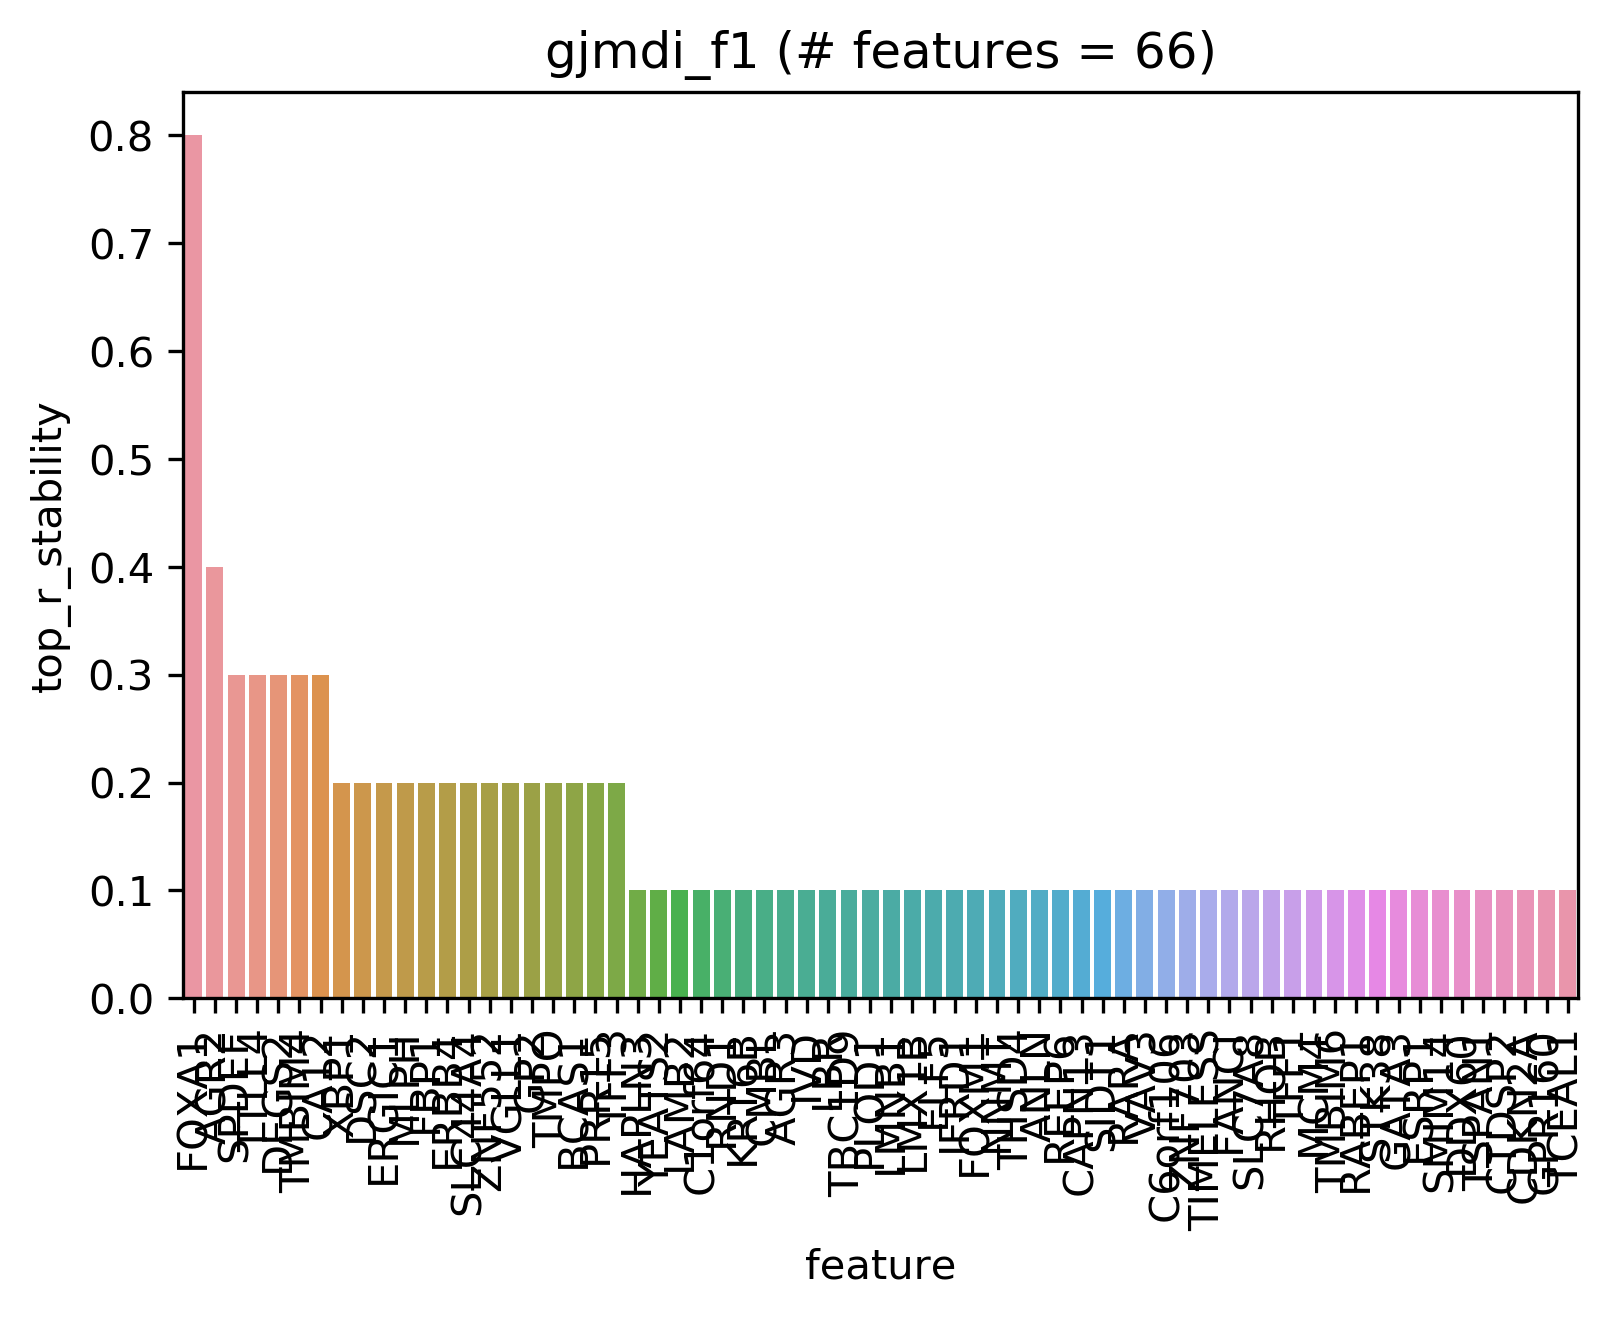

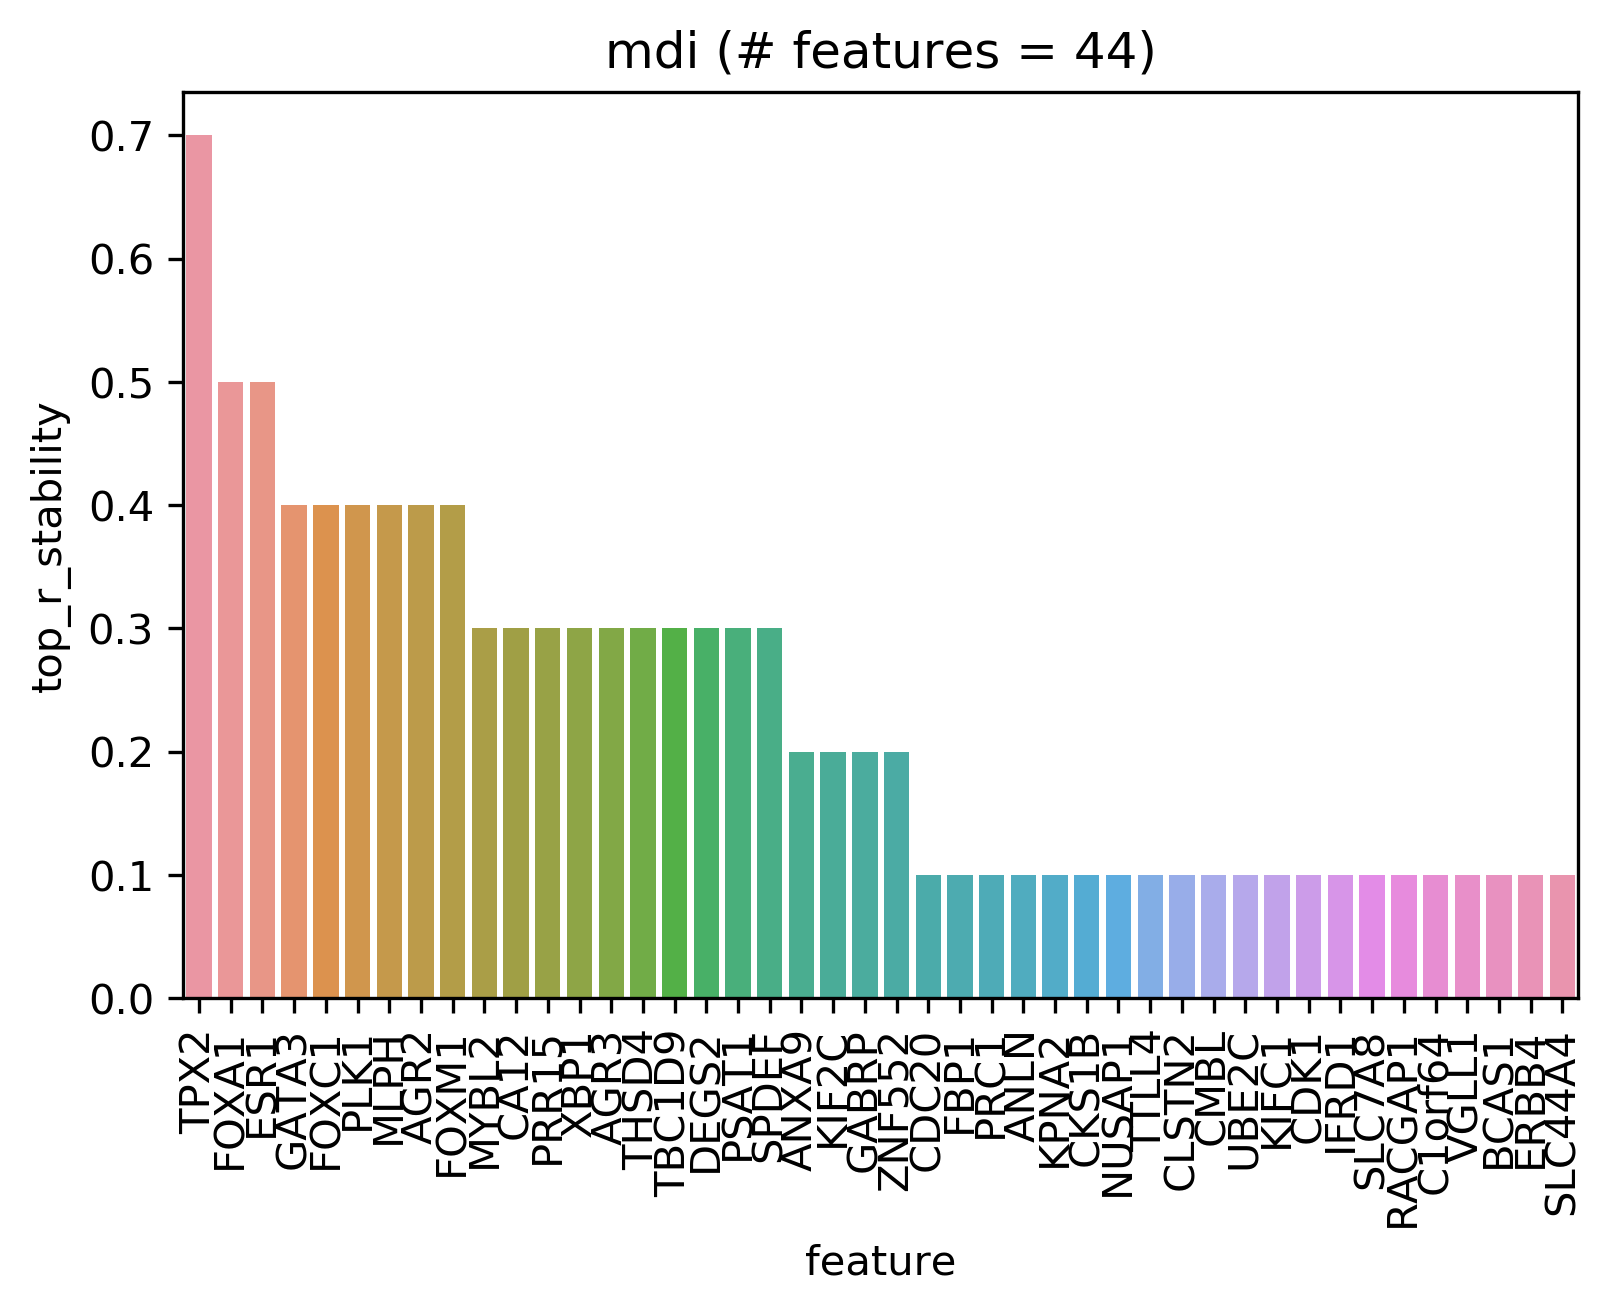

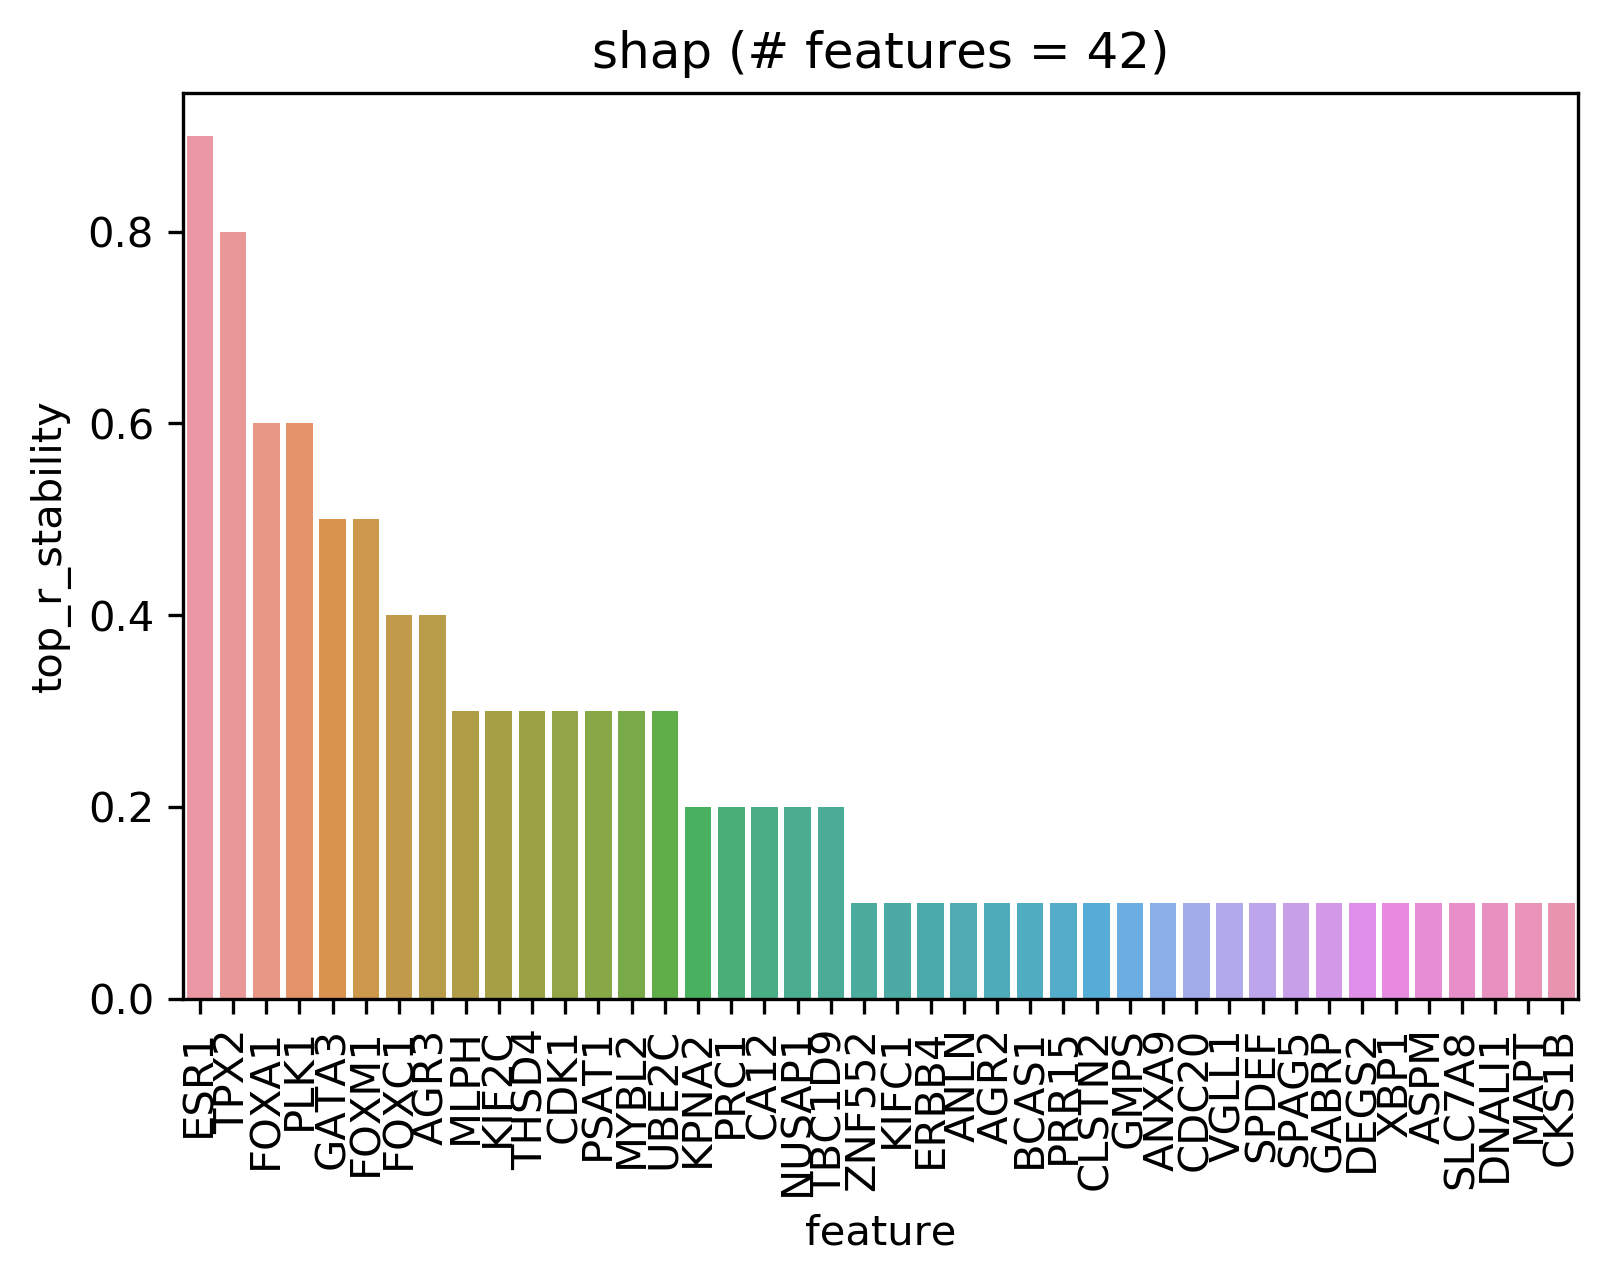

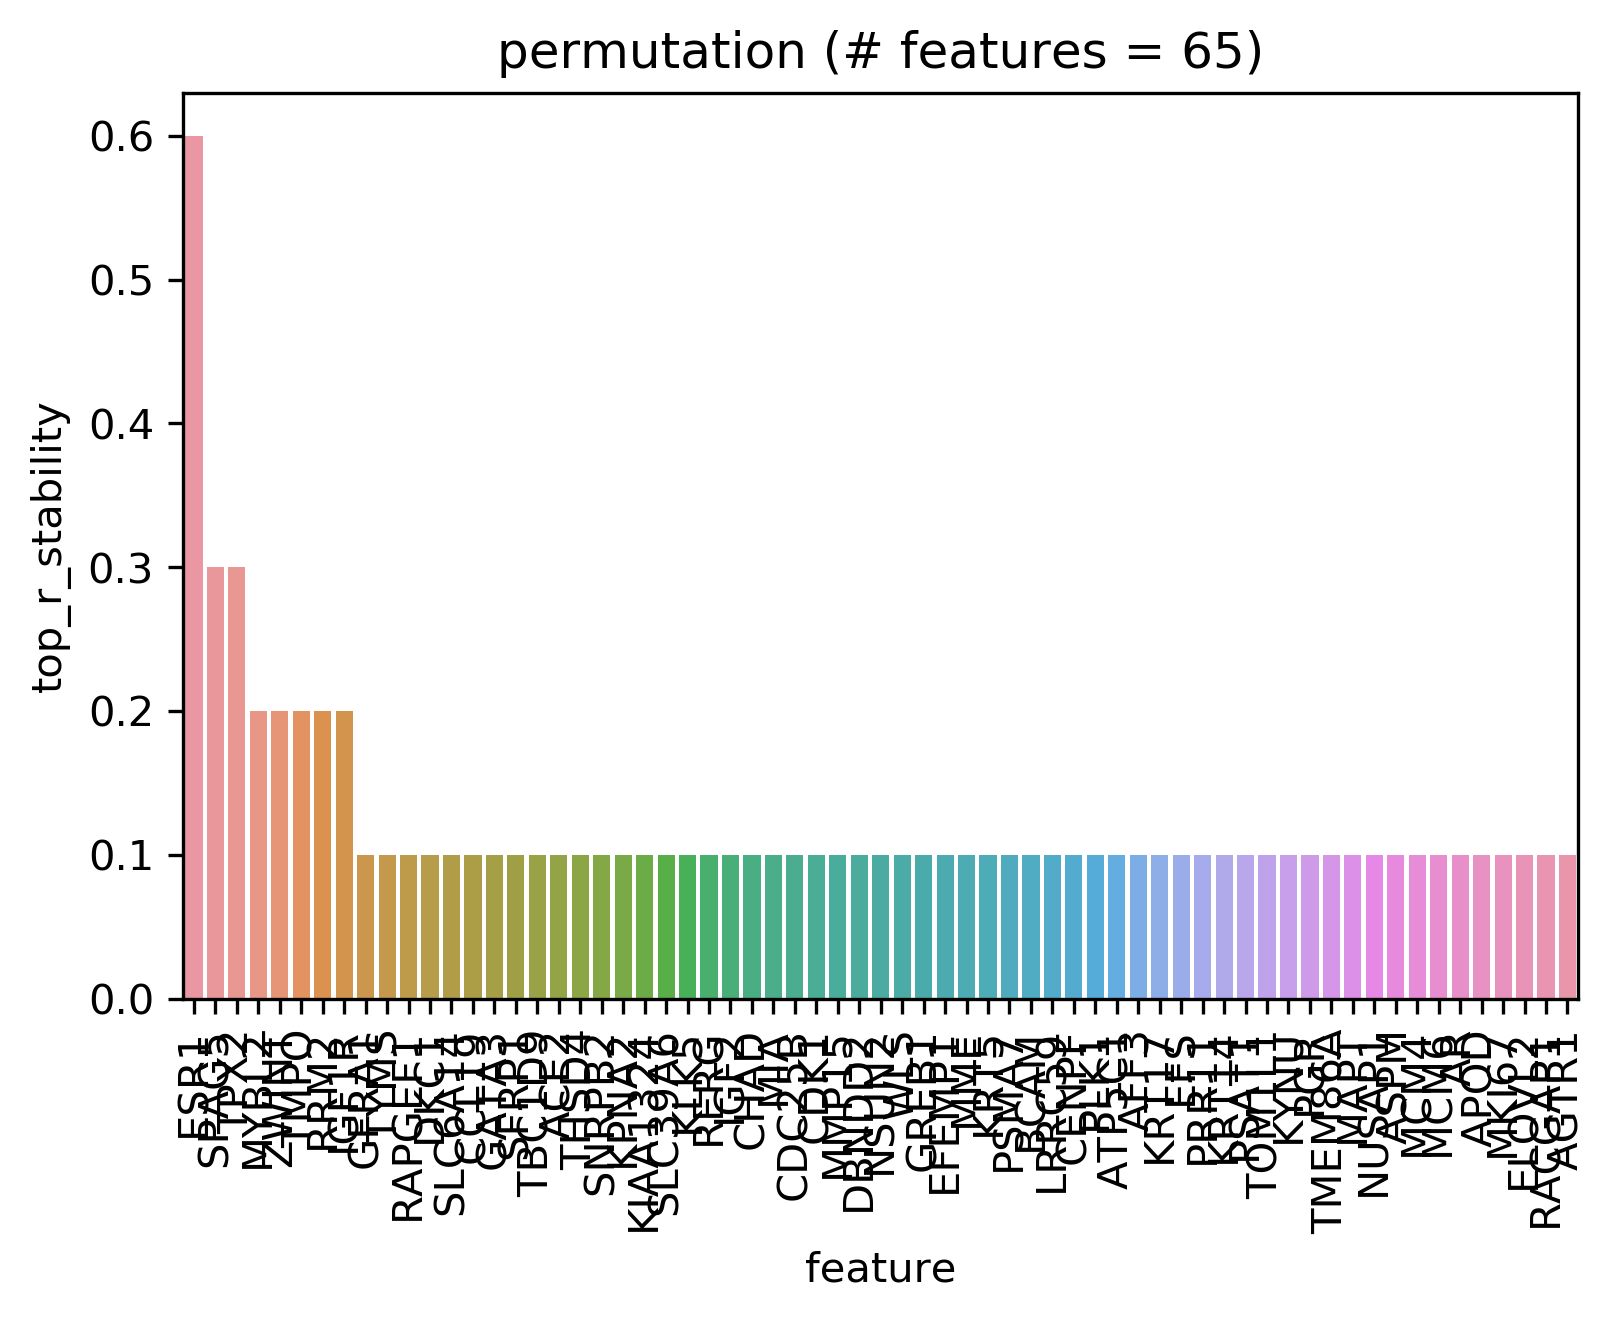

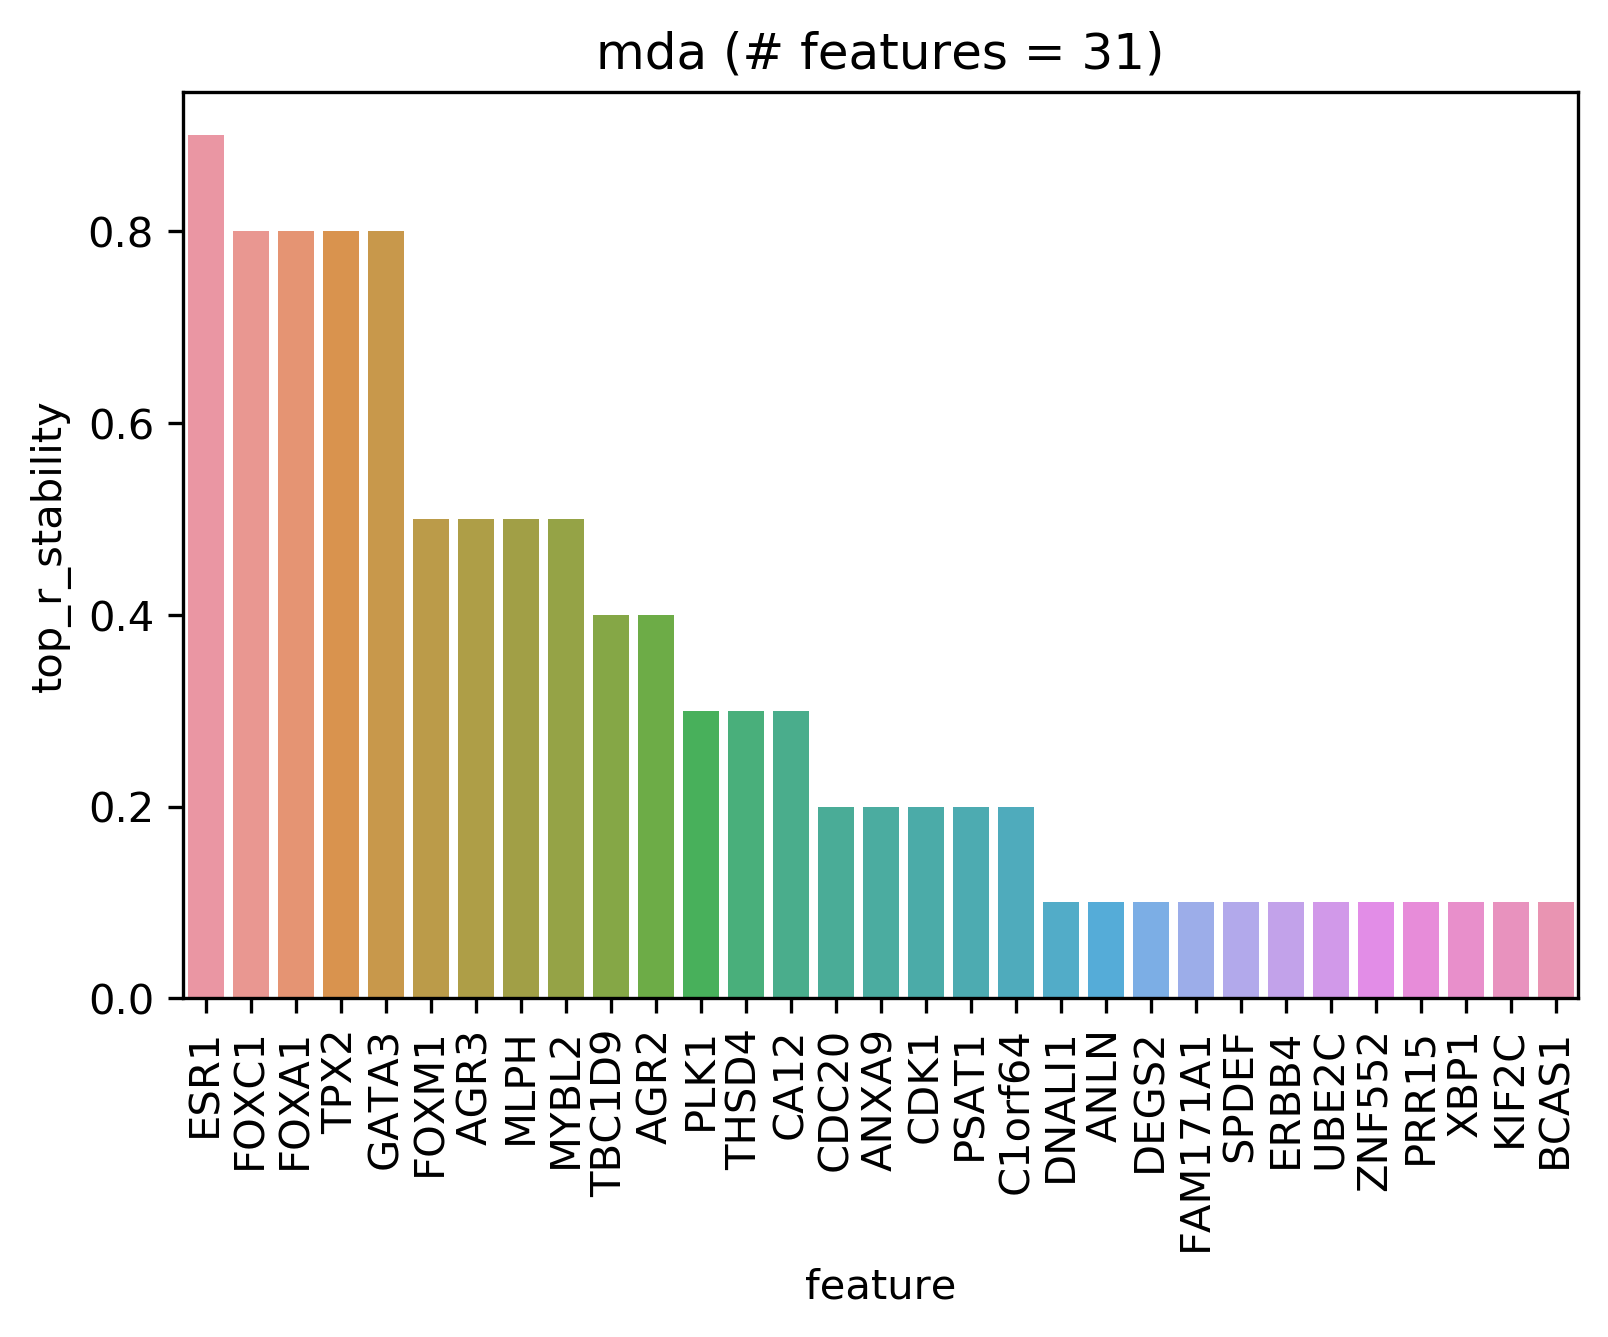

In [25]:
for key, df in stability_dict.items():
    df = df[df["top_r_stability"] > 0]
    ax = sns.barplot(
        x="feature", y="top_r_stability", data=df,
        order=df.sort_values("top_r_stability", ascending=False)["feature"]
    )
    ax.set_title("{} (# features = {})".format(key, df.shape[0]))
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    plt.show()

In [27]:
imp_df = dict_to_df(imp_dict, "method")
imp_df

,0,1,2,3,4,5,6,7,8,9,feature,method
0,-0.665831,-0.661924,-0.664784,-0.664343,-0.664893,-0.663706,-0.665791,-0.662762,-0.664317,-0.666209,A2M,gjmdi_loocv
1,-0.662533,-0.658207,-0.662146,-0.663204,-0.660136,-0.659563,-0.661736,-0.657861,-0.660137,-0.662083,NAT1,gjmdi_loocv
2,-0.665673,-0.661365,-0.664121,-0.664184,-0.663576,-0.662804,-0.665021,-0.662597,-0.663906,-0.666189,RP11.986E7.7,gjmdi_loocv
3,-0.665830,-0.671683,-0.664665,-0.664618,-0.664970,-0.663535,-0.667354,-0.662751,-0.664128,-0.668491,AAMP,gjmdi_loocv
4,-0.665830,-0.661445,-0.664666,-0.664202,-0.664082,-0.663535,-0.665502,-0.662508,-0.664725,-0.665935,AARS,gjmdi_loocv


In [28]:
stability_df = dict_to_df(stability_dict, "method")
stability_df

,feature,top_r_stability,method
0,ESR1,1.0,gjmdi_loocv
1,FOXM1,0.9,gjmdi_loocv
2,TPX2,0.9,gjmdi_loocv
3,GATA3,0.8,gjmdi_loocv
4,FOXA1,0.7,gjmdi_loocv
...,...,...,...
29995,RORC,0.0,mda
29996,ROCK1,0.0,mda
29997,ROBO2,0.0,mda
29998,ROBO1,0.0,mda


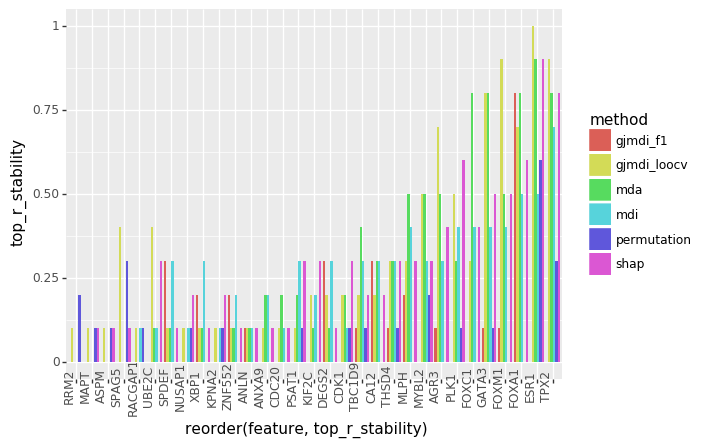

<ggplot: (8780353131873)>

In [37]:
keep_features = stability_dict["gjmdi_loocv"][stability_dict["gjmdi_loocv"]["top_r_stability"] > 0]["feature"]
ggplot(stability_df[stability_df["feature"].isin(keep_features)]) +\
    aes(x="reorder(feature, top_r_stability)", y="top_r_stability", fill="method") +\
    geom_bar(stat="identity", position="dodge") +\
    theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1))

## Visualize Class Scores